In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

## Creating the initial optic

We start with creating a conical lens defaulted to be a parabola (k=-1) with N=1000 points to span the space of the top half of the lens. One can start with other conical shapes by inputting the corresponding k value. The inputs are `thick` or the thickness of the lens and `R` which is the radius of curvature. The code only simulates the top half of the optic due to the assumption that the surface is cylindrically symmetric. The equation of the optic is derived from the equation for a conic section with the apex at the origin and solving for r:

\begin{align}
    r^2-2Rz+(K+1)z^2=0\\
    r=\sqrt{2Rz+(K+1)z^2}
\end{align}

One can plug in:
- k=-1 for parabola
- k=0 for spherical
- k>0 for oblate ellipse
- 0>K>−1 for prolate ellipse
- k<-1 for hyperbola

When plugging in the the values for `thick` and `R` one should keep in mind the thin lens approximation where the thickness << R

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.geomspace(1e-6,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

## Finding the slope for refraction/reflection

The goal of this is to find the normal to any shaped surface. The normal slope will be 1/m for reflected and -1/m for refracted where m is the tangent/slope of the surface at that point

In [3]:
def find_local_eq(r,optic,N=1000):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index
    lower=index-5
    upper=index+5
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    # Use cubic spline to interpolate the local points
    cs=CubicSpline(local_z,local_opt)
    zs=np.linspace(local_z[0],local_z[-1],N)
    return zs,cs

In [4]:
def find_norm(z,cs):
    # find the normal to the surface
    tang=cs(z,1) # 1st derivative of the spline at point z
    norm=-1/tang
    return norm

`find__refract_slope` finds the slope of the ray after it refracts off of the surface. `norm` is the normal of the surface and is used to find the angle $\phi1$ which is the angle between the incident ray and the normal of the surface. This function returns the slope of the ray that refracts after encountering the surface using Snell's law. Will probably need to rethink geometries later

In [5]:
def find_refract_slope(norm,n1,n2):
    phi1=np.arctan(norm)
    sinphi2=n1*np.sin(phi1)/n2
    phi2=np.arcsin(sinphi2)
    theta=phi1-phi2
    slope=np.tan(theta)
    return slope

In [12]:
def snells_law(norm,n1,n2):
    theta1=np.arctan(norm)
    theta2=np.arcsin(n1/n2*np.sin(theta1))
    slope=np.tan(theta2)
    return slope

## Refraction Raytracing

Now that we have the algorithm to find the slope normal to the surface we can simulate the ray propagation. We only need to calculate for two points:where the ray meets the surface the optic and where the ray crosses the optical axis. Additional functionality can be added later for multiple optics. Also need to change the input rays to be ray vectors instead. This code does both refraction and reflection.

In [26]:
def raytrace(optic, Nr=7):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[5]
    r_max=opt[-10]
    
    rays=np.linspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic 
    for r in rays:
        zs,cs=find_local_eq(r,optic)
        z_optic=cs.roots()
        if len(z_optic)>1:
            print('Warning: multiple intersections with lens found') # many roots are usually found near r=0
        
        norm=find_norm(z_optic[0],cs)
        slope=find_refract_slope(norm,1,1.5)
        r_thick=r+slope*(2-z_optic[0])
        s_after=snells_law(slope,1.5,1)
        z_after=(-r_thick/s_after+2) # This is where the ray should intersect the z axis
        print(z_after)
        z_bef=-1 
        z_ray=[-1,z_optic[0],2,z_after]
        r_ray=[r,r,r_thick,0]            
        raymatrix.append([z_ray,r_ray])
    return np.array(raymatrix)

In [27]:
def plot(optic,raymatrix,title):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    plt.plot(optic[0],optic[1],'b',optic[0],-1*optic[1],'b')
    r_max=max(optic[1])
    plt.vlines(2,-r_max,r_max,'b')
    #Then plot the rays:
    for ray in raymatrix:
        plt.plot(ray[0],ray[1],'r',ray[0],-1*ray[1],'r')
    plt.xlabel('z')
    plt.ylabel('r')
    plt.title(title)
    plt.show()

40.666719424915826
40.67455156382504
40.688876867752924
40.71816828971051
40.755486446089535
40.80600014429
40.867422707193434
40.938221490831175
41.022703187717866
41.11485364576773


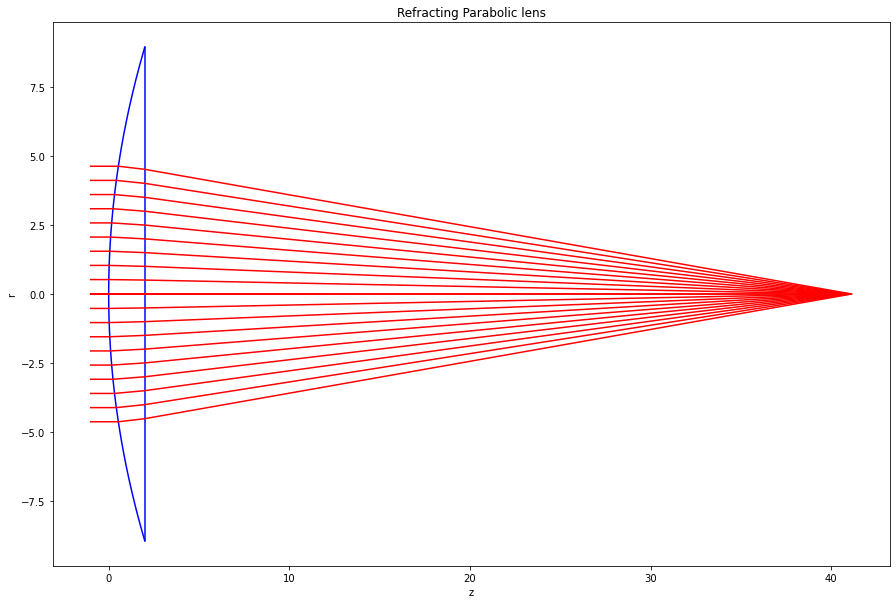

In [33]:
o=create_starting_optic(2,20)
rm=raytrace(o,Nr=10)
plot(o,rm,"Refracting Parabolic lens")